In [ ]:
# Copyright (c) 2026 Nima Sharifinia
# Licensed under the Apache License, Version 2.0

In [ ]:
path = "/home/nima/Nima/Project_img_cap_nima/datasets/flickr30k"
load = True
load_path = "trained_models/flickr models/transformer_7.pth"

Imports

In [2]:
# !pip install torch_geometric

In [5]:
import json
import cv2
import numpy as np
# import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import os
import sys
from torchvision import transforms
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import csv

# from torch_geometric.nn import GCNConv
# from torch_geometric.data import Data
# from torch_geometric.nn import SAGEConv  # Importing SAGEConv
# from torch_geometric.nn import GraphConv
# from torch_geometric.nn import global_mean_pool

# Dataset

In [3]:
BATCH_SIZE = 256
feature_extraction_model = "xception"

Builiding vocab and tokenizer

In [4]:
class CustomTokenizer:
    def __init__(self, num_words=None, oov_token="<unk>"):
        self.num_words = num_words
        self.oov_token = oov_token
        self.max_length = 0
        self.word_to_idx = {}
        self.idx_to_word = {}

    def clean_text(self, text):
        # Convert to lowercase and remove punctuation (except spaces)
        text = text.lower()
        text = re.sub(r'[!"#$%&()*+.,-/:;=?@[\]^_`{|}~]', '', text)
        return text

    def fit_on_texts(self, texts):
        word_counts = {}

        # Split sentences into words correctly
        for text in texts:
            cleaned_text = self.clean_text(text)  # Proper cleaning
            words = cleaned_text.split()  # Split sentence into words
            if self.max_length < len(words):
              self.max_length = len(words)
            for word in words:
                word_counts[word] = word_counts.get(word, 0) + 1

        # Sort words by frequency
        sorted_vocab = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

        # Limit vocab to num_words (excluding OOV)
        vocab_size = self.num_words - 1 if self.num_words else len(sorted_vocab)

        # Build the word_to_idx and idx_to_word dictionaries
        self.word_to_idx = {
            "<pad>": 0,
            "<unk>": 1,
        }
        self.idx_to_word = {
            0: "<pad>",
            1: "<unk>",
        }

        for idx, (word, _) in enumerate(sorted_vocab[:vocab_size], start=2):
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word

    def text_to_sequence(self, text):
        cleaned_text = self.clean_text(text)
        words = cleaned_text.split()  # Ensure proper tokenization
        return [self.word_to_idx.get(word, self.word_to_idx["<unk>"]) for word in words]  # Map to index
    
    def decode(self, tokens, skip_start=False):
        words = []
        for idx in tokens:
            word = self.idx_to_word.get(idx, "<unk>")
            if skip_start and word == "<start>":
                continue
            if word == "<end>":
                break
            words.append(word)
        return ' '.join(words)

Flickr30k Dataset


In [6]:
import os.path
class FlickrDataset(Dataset):
    def __init__(self, transform=None, max_len=100):
        self.transform = transform
        self.all_captions = []
        self.all_images = []
        self.all_ids = []
        self.all_refs = defaultdict(list)
        self.max_length = max_len
        self.PATH = f"{path}/Images/"

        with open(f'{path}/captions.txt', 'r', encoding='utf-8') as infile:
            reader = csv.reader(infile)
            next(reader)  # Skip header
            for image_id, caption in reader:
                self.all_refs[image_id].append(caption)
                caption = '<start> ' + caption + ' <end>'
                full_flickr_image_path = self.PATH + image_id
                if not image_id in self.all_ids:
                    self.all_ids.append(image_id)
                    self.all_images.append(full_flickr_image_path)
                    self.all_captions.append(caption)
        self.all_captions = [' '.join(caption.split()[:self.max_length]) for caption in self.all_captions]

    def encode(self, caption):
        caption = tokenizer.clean_text(caption)
        encoded_caption = tokenizer.text_to_sequence(caption)
        remain = tokenizer.max_length - len(encoded_caption)
        for i in range(remain):
            encoded_caption.append(0)

        return torch.tensor(encoded_caption)

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.all_captions)

    def __getitem__(self, idx):
        """Fetches the image and encoded caption at the specified index."""
        image_name = self.all_images[idx]

        img_features = np.load(image_name + "_" + feature_extraction_model + '.npy')
        reltr_features = np.load(image_name + "_reltr_gat.npy")

        caption = self.all_captions[idx]

        encoded_caption = self.encode(caption)

        return image_name, img_features, reltr_features, caption, encoded_caption

# Example usage
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure 3 channels (convert grayscale to RGB)
    transforms.ToTensor(),
])

# Create the custom dataset
dataset = FlickrDataset(transform=transform, max_len=45)
dataset_len = len(dataset)

tokenizer = CustomTokenizer(num_words=3000, oov_token="<unk>")
tokenizer.fit_on_texts(dataset.all_captions)

In [7]:
import pickle
with open("tokenizer_flickr.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [7]:
from torch.utils.data import random_split

# Define split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split the dataset
dataset, val_dataset = random_split(dataset, [train_size, val_size])

Dataloader

In [8]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Model

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Encoder and Decoder

In [10]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, embedding_dim).to(device)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1024, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        T = x.size(0)
        x = x + self.pe[:T].unsqueeze(1)
        return self.dropout(x)

class CaptionDecoder(nn.Module):
    def __init__(self, vocab_size, d_model=512, nheads=8, num_layers=6, dim_ff=2048, dropout=0.1, pad_idx=0):
        super().__init__()
        self.d_model = d_model
        self.pad_idx = pad_idx

        self.tok_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_enc = PositionalEncoding(d_model, max_len=100, dropout=dropout)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nheads, dim_feedforward=dim_ff, dropout=dropout, batch_first=False
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.out = nn.Linear(d_model, vocab_size)
        self.out.weight = self.tok_emb.weight  # tie weights

    def forward(self, tgt_tokens, memory, tgt_key_padding_mask=None):
        # tgt_tokens: (T, B)
        tgt_emb = self.tok_emb(tgt_tokens) * math.sqrt(self.d_model)
        tgt_emb = self.pos_enc(tgt_emb)

        T = tgt_tokens.size(0)
        causal_mask = torch.triu(torch.ones(T, T, device=tgt_tokens.device), diagonal=1).bool()

        dec_out = self.decoder(
            tgt=tgt_emb,
            memory=memory,  # (S=101, B, E)
            tgt_mask=causal_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        logits = self.out(dec_out)  # (T, B, V)
        return logits



### Image Captioner Model

In [11]:
class ImageCaptioner(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode_image(self, img_feats):
        # img_feats: (B, 101, input_dim)
        mem = self.encoder(img_feats)         # (B, 101, d_model)
        mem = mem.transpose(0, 1)              # (S=101, B, d_model)
        return mem

    def forward(self, img_feats, tgt_tokens, tgt_key_padding_mask=None):
        memory = self.encode_image(img_feats)
        logits = self.decoder(tgt_tokens, memory, tgt_key_padding_mask)
        return logits


In [12]:
def make_tgt_inputs(target_seqs, pad_idx, eos_idx):
    """
    target_seqs: (B, L=51) with <start> at pos 0 and <end> somewhere before padding.
    pad_idx: index of <pad>
    eos_idx: index of <end>
    """
    # Shift for teacher forcing
    dec_inp = target_seqs[:, :-1]   # remove last token
    dec_tgt = target_seqs[:, 1:]    # remove first token

    # Replace anything after <end> in dec_tgt with pad_idx
    # so model is not trained to predict random tokens after EOS.
    for i in range(dec_tgt.size(0)):
        eos_pos = (dec_tgt[i] == eos_idx).nonzero(as_tuple=True)[0]
        if len(eos_pos) > 0:
            first_eos = eos_pos[0].item()
            if first_eos + 1 < dec_tgt.size(1):
                dec_tgt[i, first_eos+1:] = pad_idx

    # Transpose to (T, B) for transformer
    dec_inp = dec_inp.transpose(0, 1)
    dec_tgt = dec_tgt.transpose(0, 1)

    # Padding mask for the decoder: True where PAD
    tgt_key_padding_mask = (dec_inp.transpose(0, 1) == pad_idx)  # (B, T)

    return dec_inp, dec_tgt, tgt_key_padding_mask



### Hyper Parameters

In [13]:
vocab_size = len(tokenizer.word_to_idx)
input_dim = 2048  # feature vector size per region
d_model = 256
nheads = 8
num_layers = 2
dropout = 0.3

encoder = CNN_Encoder(input_dim=input_dim, embedding_dim=d_model).to(device)
decoder = CaptionDecoder(vocab_size=vocab_size, d_model=d_model, nheads=nheads, num_layers=num_layers, dropout=dropout, pad_idx=tokenizer.word_to_idx["<pad>"]).to(device)

model = ImageCaptioner(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word_to_idx["<pad>"], label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)


In [14]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch, (img_name, img_feats, reltr_feats, _, enc_caps) in enumerate(dataloader):
        img_feats = img_feats.float().to(device)  # (B, 102, 2048)
        reltr_feats = reltr_feats.float().to(device)
        feats = torch.cat((img_feats, reltr_feats.squeeze(1)), dim=1).to(device)

        enc_caps = enc_caps.long().to(device)

        dec_inp, dec_tgt, pad_mask = make_tgt_inputs(enc_caps, tokenizer.word_to_idx["<pad>"], tokenizer.word_to_idx["<end>"])

        logits = model(feats, dec_inp, pad_mask)

        loss = criterion(logits.reshape(-1, logits.size(-1)), dec_tgt.reshape(-1))

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    for batch in dataloader:
        img_name, img_feats, reltr_feats, _, enc_caps = batch
        

        img_feats = img_feats.float().to(device)  # (B, 102, 2048)
        reltr_feats = reltr_feats.float().to(device)
        feats = torch.cat((img_feats, reltr_feats.squeeze(1)), dim=1).to(device)
        enc_caps = enc_caps.long().to(device)

        dec_inp, dec_tgt, pad_mask = make_tgt_inputs(enc_caps, tokenizer.word_to_idx["<pad>"], tokenizer.word_to_idx["<end>"])
        logits = model(feats, dec_inp, pad_mask)
        loss = criterion(logits.reshape(-1, logits.size(-1)), dec_tgt.reshape(-1))
        total_loss += float(loss.item())
    return total_loss / max(1, len(dataloader))


In [16]:
def decode_tokens(token_ids, tokenizer, eos_idx):
    words = []
    for idx in token_ids:
        if idx == eos_idx:
            break
        if idx in tokenizer.idx_to_word:
            w = tokenizer.idx_to_word[idx]
            if w not in ("<start>", "<pad>"):
                words.append(w)
        else:
            words.append("<unk>")
    return " ".join(words)

@torch.no_grad()
def generate_caption(model, img_feats, reltr_feats, tokenizer, max_len=tokenizer.max_length, device="cuda", temperature=1.0):
    model.eval()
    img_feats = torch.from_numpy(img_feats).float().unsqueeze(0).to(device)
    reltr_feats = torch.from_numpy(reltr_feats).float().to(device)
    feats = torch.cat((img_feats, reltr_feats), dim=1).to(device)

    memory = model.encode_image(feats)

    PAD_IDX = tokenizer.word_to_idx["<pad>"]
    BOS_IDX = tokenizer.word_to_idx["<start>"]
    EOS_IDX = tokenizer.word_to_idx["<end>"]

    ys = torch.tensor([[BOS_IDX]], dtype=torch.long, device=device)  # (1, 1)

    for _ in range(max_len - 1):
        tgt_key_padding_mask = (ys.transpose(0, 1) == PAD_IDX)  # (1, T)

        # Call full forward pass of decoder (already includes self.out)
        logits = model.decoder(ys, memory, tgt_key_padding_mask)  # (T, 1, vocab_size)

        next_token_logits = logits[-1, 0, :]  # Last timestep's vocab scores
        
        # Apply temperature scaling
        next_token_logits = next_token_logits / temperature
        
        # Convert logits to probabilities
        probs = F.softmax(next_token_logits, dim=-1)
        
        # Sample the next token (instead of using argmax)
        next_id = torch.multinomial(probs, 1).item()

        ys = torch.cat([ys, torch.tensor([[next_id]], device=device)], dim=0)

        if next_id == EOS_IDX:
            break

    pred_ids = ys.squeeze(1).tolist()
    caption = decode_tokens(pred_ids, tokenizer, EOS_IDX)
    return caption

In [17]:
dataset = None

In [19]:
best_val_loss = float('inf')
best_model = None
EPOCHS = 40
loss_plot = []
val_loss_plot = []

if not load:
    for epoch in range(1, EPOCHS+1):
        tr_loss = train_one_epoch(model, dataloader, optimizer, criterion, device)
        val_loss = evaluate(model, val_dataloader, criterion, device)
        loss_plot.append(tr_loss)
        val_loss_plot.append(val_loss)
        
        print(f"Epoch {epoch:02d} | train CE: {tr_loss:.3f} | val CE: {val_loss:.3f}")

        img_name, img_feats, reltr_feats, _, enc_caption = val_dataset[1]

        caption = generate_caption(model, img_feats, reltr_feats, tokenizer, max_len=tokenizer.max_length, device=device, temperature=0.5)
        print("Generated caption:", caption)
        
        scheduler.step(val_loss)

        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, 'best_model.pth')
            print(f"Model saved at epoch {epoch}")
else:
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_loss = checkpoint['loss']


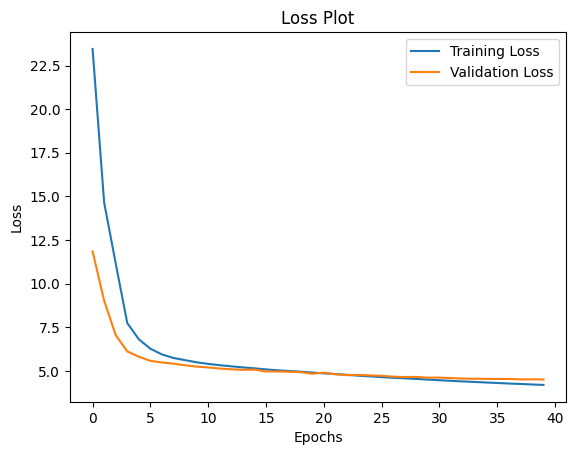

In [19]:
plt.plot(loss_plot, label='Training Loss')
plt.plot(val_loss_plot, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [ ]:
# Pick a sample from validation set
image_name, img_feats, reltr_feats, _, _ = val_dataset[101]

caption = generate_caption(model, img_feats, reltr_feats, tokenizer, max_len=tokenizer.max_length, device=device, temperature=0.1)
print("Image:", image_name)
print("Generated caption:", caption)


In [21]:
image_name = "/home/nima/Downloads/coco2017/train2017/000000314700.jpg"

img_features = np.load(image_name + "_" + feature_extraction_model + '.npy')
reltr_features = np.load(image_name + "_reltr.npy")

caption = generate_caption(model, img_features, reltr_features, tokenizer, tokenizer.max_length, device, temperature=0.1)
print(image_name)
print(caption)

/home/nima/Downloads/coco2017/train2017/000000314700.jpg
a woman in a black dress and a black dress is holding a <unk>


In [21]:
import json

# Containers for COCO-style ground truth and predictions
annotations = []
images = []
results = []

ann_id = 0
total = len(val_dataset)

for i, index in enumerate(val_dataset.indices):
    # Unpack data
    img_name, img_features, reltr_features, caption, encoded_caption = val_dataset.dataset[index]
    image_id = val_dataset.dataset.all_ids[index]

    # Generate model prediction
    generated_caption = generate_caption(
        model, img_features, reltr_features,
        tokenizer, max_len=tokenizer.max_length,
        device=device, temperature=0.1
    )

    # Append to ground truth annotations
    for ref_caption in val_dataset.dataset.all_refs[image_id]:
        annotations.append({
            "image_id": image_id,
            "id": ann_id,
            "caption": ref_caption
        })
        ann_id += 1

    # Append to predictions
    results.append({
        "image_id": image_id,
        "caption": generated_caption
    })

    # Track image IDs
    images.append({"id": image_id})

    print(f"{i+1}/{total}")

# Save predictions to results.json
with open("results.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2)

# Save ground truth to annotations.json
coco_gt = {
    "images": images,
    "annotations": annotations
}
with open("annotations.json", "w", encoding="utf-8") as f:
    json.dump(coco_gt, f, indent=2)

print("✅ Saved results.json and annotations.json")


1/6357
2/6357
3/6357
4/6357
5/6357
6/6357
7/6357
8/6357
9/6357
10/6357
11/6357
12/6357
13/6357
14/6357
15/6357
16/6357
17/6357
18/6357
19/6357
20/6357
21/6357
22/6357
23/6357
24/6357
25/6357
26/6357
27/6357
28/6357
29/6357
30/6357
31/6357
32/6357
33/6357
34/6357
35/6357
36/6357
37/6357
38/6357
39/6357
40/6357
41/6357
42/6357
43/6357
44/6357
45/6357
46/6357
47/6357
48/6357
49/6357
50/6357
51/6357
52/6357
53/6357
54/6357
55/6357
56/6357
57/6357
58/6357
59/6357
60/6357
61/6357
62/6357
63/6357
64/6357
65/6357
66/6357
67/6357
68/6357
69/6357
70/6357
71/6357
72/6357
73/6357
74/6357
75/6357
76/6357
77/6357
78/6357
79/6357
80/6357
81/6357
82/6357
83/6357
84/6357
85/6357
86/6357
87/6357
88/6357
89/6357
90/6357
91/6357
92/6357
93/6357
94/6357
95/6357
96/6357
97/6357
98/6357
99/6357
100/6357
101/6357
102/6357
103/6357
104/6357
105/6357
106/6357
107/6357
108/6357
109/6357
110/6357
111/6357
112/6357
113/6357
114/6357
115/6357
116/6357
117/6357
118/6357
119/6357
120/6357
121/6357
122/6357
123/6357
1

In [22]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

annotation_file = 'annotations.json'

results_file = './results.json'

# create coco object and coco_result object
coco = COCO(annotation_file)
coco_result = coco.loadRes(results_file)

# create coco_eval object by taking coco and coco_result
coco_eval = COCOEvalCap(coco, coco_result)

# evaluate on a subset of images by setting
# coco_eval.params['image_id'] = coco_result.getImgIds()
# please remove this line when evaluating the full validation set
# coco_eval.params['image_id'] = coco_result.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
coco_eval.evaluate()

# print output evaluation scores
for metric, score in coco_eval.eval.items():
    print(f'{metric}: {score:.3f}')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 457989 tokens at 4464342.85 tokens per second.
PTBTokenizer tokenized 118403 tokens at 2199046.27 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 112047, 'reflen': 91966, 'guess': [112047, 105690, 99333, 92976], 'correct': [53554, 24058, 9597, 3980]}
ratio: 1.2183524345953807
Bleu_1: 0.478
Bleu_2: 0.330
Bleu_3: 0.219
Bleu_4: 0.146
computing METEOR score...
METEOR: 0.174
computing Rouge score...
ROUGE_L: 0.407
computing CIDEr score...
CIDEr: 0.240
computing SPICE score...


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.1 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.5 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.2 sec].
Loading classif

SPICE evaluation took: 2.302 min
SPICE: 0.123
Bleu_1: 0.478
Bleu_2: 0.330
Bleu_3: 0.219
Bleu_4: 0.146
METEOR: 0.174
ROUGE_L: 0.407
CIDEr: 0.240
SPICE: 0.123
